In [1]:
%matplotlib inline


Training a ResNet Classifier for Cifar10
=====================


# ResNet

ResNet is proposed in the following paper:

- Kaiming He, Xiangyu Zhang, Shaoqing Ren and Jian Sun (2015), "Deep Residual Learning for Image Recognition", [CVPR 2016](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf "CVPR'2016 paper"), arXiv:1512.03385v1. 

On the ImageNet competition, an ensemble of ResNets with up to 152 layers achieves 3.57% top-5 test error and wins the championships of ImageNet detection, ImageNet localization, COCO detection, and COCO segmentation in ILSVRC & COCO 2015.   

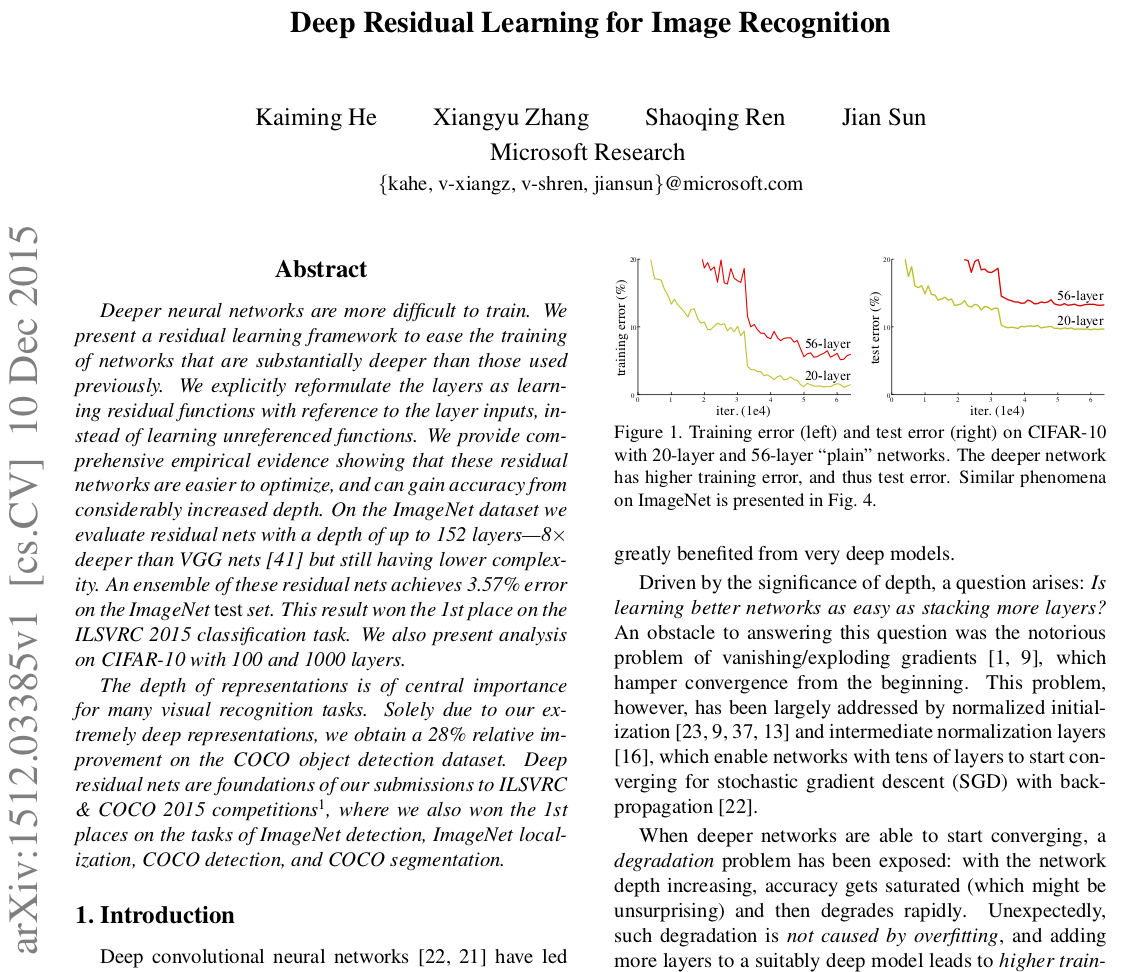

In [2]:
from IPython.display import Image
Image(filename='graphics/ResNet_paper.png')

### ResNet residue structure
The key in ResNet for very deep networks without suffering the vanishing gradient issue, lies in the introduction of residual block structure.

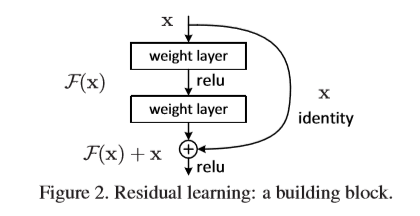

In [3]:
Image(filename='graphics/residue.png') # <img src="./graphics/residue.png" alt="drawing" width="800"/>

### ResNet model

Original ResNet models are illustrated below, with shortcuts in a comparison with VGG-19 and plain convolutional networks.  

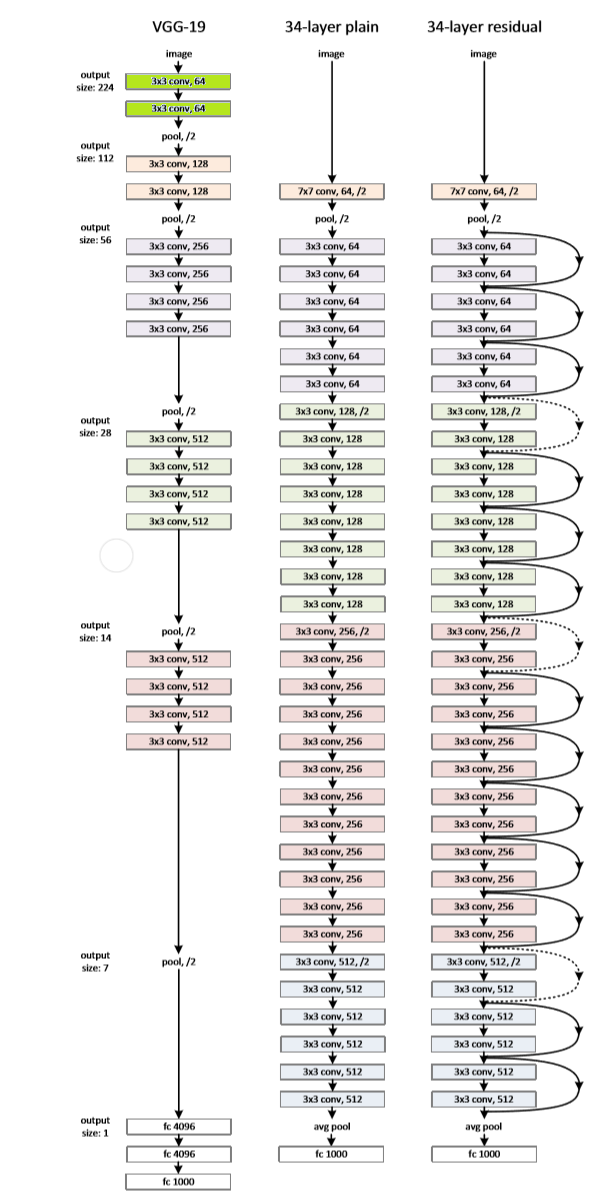

In [4]:
Image(filename='graphics/resnet-architecture.png') # <img src="./graphics/resnet-architecture.png" alt="drawing" width="600"/>

whose residual block structures are illustrated in 

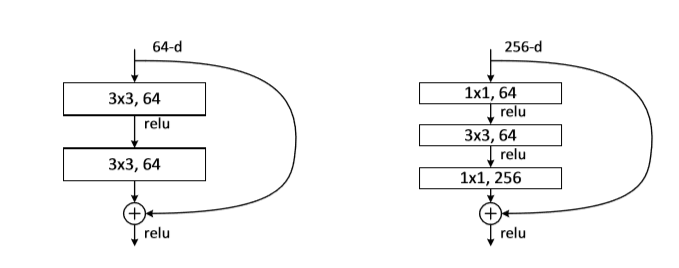

In [5]:
Image(filename='graphics/resblock.png') #<img src="./graphics/resblock.png" alt="drawing" width="600"/>

Here we adopt a simplified ResNet module tailored for Cifar10 dataset. 

In [6]:
# Define the ResNet module
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])

In [7]:
model = ResNet18()

In [8]:
# Assume that we are on a CUDA machine, then this should print a CUDA device:
import os
import torch
from torchsummary import summary

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
use_gpu = torch.cuda.is_available()

device = torch.device("cuda" if use_gpu else "cpu")
print(device)

if use_gpu:
    model = model.cuda()
    
summary(model, input_size=(3, 32, 32), device="cuda" if use_gpu else "cpu") 

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [10]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

BATCH_SIZE = 100
batch_size_train = 100 # 200
batch_size_test = 100  # 1000

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_train,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size_test,
                                         shuffle=False, num_workers=2)

loaders = {'train': trainloader, 'test': testloader}

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



horse truck plane  frog


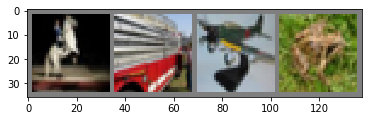

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[0:4,]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [12]:
# Define a function for training process, returning training (test) loss and errors
import os
import re
import time
import scipy.stats

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


def train_model(model, criterion, optimizer, log_saver, num_epochs=100):
    since = time.time()
    steps = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'test']:

            loss_meter = AverageMeter()
            acc_meter = AverageMeter()
            margin_error_meter = AverageMeter()

            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            for i, data in enumerate(loaders[re.findall('[a-zA-Z]+',
                                                        phase)[0]]):
                inputs, labels = data
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)

                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    steps += 1

                N = outputs.size(0)

                loss_meter.update(loss.data.item(), N)
                acc_meter.update(
                    accuracy(outputs.data, labels.data)[-1].item(), N)

            epoch_loss = loss_meter.avg
            epoch_error = 1 - acc_meter.avg / 100

            if phase == 'train':
                log_saver['train_loss'].append(epoch_loss)
                log_saver['train_error'].append(epoch_error)

            elif phase == 'test':

                log_saver['test_loss'].append(epoch_loss)
                log_saver['test_error'].append(epoch_error)

            print(
                f'{phase} loss: {epoch_loss:.4f}; error: {epoch_error:.4f}'
            )

        if epoch % 30 == 0 or epoch == num_epochs - 1:
            print('Saving..')
            state = {'net': model, 'epoch': epoch, 'log': log_saver}

            if not os.path.isdir('checkpoint_CNN'):
                os.mkdir('checkpoint_CNN')
            torch.save(state,
                       './checkpoint_CNN/ckpt_epoch_{}.t7'.format(epoch))

    time_elapsed = time.time() - since
    print(
        f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s'
    )

    return model, log_saver

In [13]:
# The log for recording train (test) loss and errors.
log = {
    'num_params': [],
    'train_loss': [],
    'train_error': [],
    'test_loss': [],
    'test_error': []
}

number_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
log['num_params'].append(number_params)

print(f'total parameters: {number_params}')

total parameters: 11173962


In [14]:
# Training parameters
num_epochs = 30
lr = 0.01
weight_decay = 0.
momentum = 0.9

In [15]:
# Train the model
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

model, log = train_model(
    model, criterion, optimizer, log, num_epochs=num_epochs)

Epoch 1/30
----------
train loss: 1.2853; error: 0.4683
test loss: 1.2181; error: 0.4202
Saving..
Epoch 2/30
----------


/home/yuany/.conda/envs/mypython3/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/yuany/.conda/envs/mypython3/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type BasicBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


train loss: 0.7583; error: 0.2657
test loss: 0.7813; error: 0.2661
Epoch 3/30
----------
train loss: 0.5252; error: 0.1845
test loss: 0.7334; error: 0.2529
Epoch 4/30
----------
train loss: 0.3779; error: 0.1330
test loss: 0.6531; error: 0.2157
Epoch 5/30
----------
train loss: 0.2534; error: 0.0891
test loss: 0.7040; error: 0.2094
Epoch 6/30
----------
train loss: 0.1789; error: 0.0640
test loss: 0.7766; error: 0.2134
Epoch 7/30
----------
train loss: 0.1179; error: 0.0419
test loss: 0.8117; error: 0.2067
Epoch 8/30
----------
train loss: 0.0774; error: 0.0267
test loss: 0.7857; error: 0.1957
Epoch 9/30
----------
train loss: 0.0502; error: 0.0178
test loss: 0.8680; error: 0.1889
Epoch 10/30
----------
train loss: 0.0415; error: 0.0153
test loss: 0.8466; error: 0.1906
Epoch 11/30
----------
train loss: 0.0343; error: 0.0114
test loss: 0.8514; error: 0.1774
Epoch 12/30
----------
train loss: 0.0254; error: 0.0087
test loss: 0.9033; error: 0.1834
Epoch 13/30
----------
train loss: 0.018

In [16]:
# Plot the results:

def plot(log, result_dir):
    fontdict = {'size': 30}

    def get_fig(i, title):
        fig = plt.figure(i, figsize=(20, 10))
        ax = fig.add_subplot(111)
        #plt.title(title, fontsize=30, y=1.04)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        return fig, ax

    fig1, ax1 = get_fig(1, 'Loss on Cifar10')
    fig2, ax2 = get_fig(2, 'Error on Cifar10')

    ax1.plot(log['train_loss'],'b', linewidth=3, label='training')
    ax1.plot(log['test_loss'],'r', linewidth=3, label='test')
    ax1.set_ylabel('loss',fontdict=fontdict)
    ax2.plot(log['train_error'],'b', linewidth=3, label='training')
    ax2.plot(log['test_error'],'r', linewidth=3, label='test')
    ax2.set_ylabel('error',fontdict=fontdict)

    for ax in [ax1, ax2]:
        ax.set_xlabel('Number of epochs', fontdict=fontdict)
        ax.legend(loc='upper right', fontsize=20)
        
    if not os.path.exists(result_dir):
        os.mkdir(result_dir)
    fig1.savefig(result_dir + 'loss.png')
    fig2.savefig(result_dir + 'error.png')



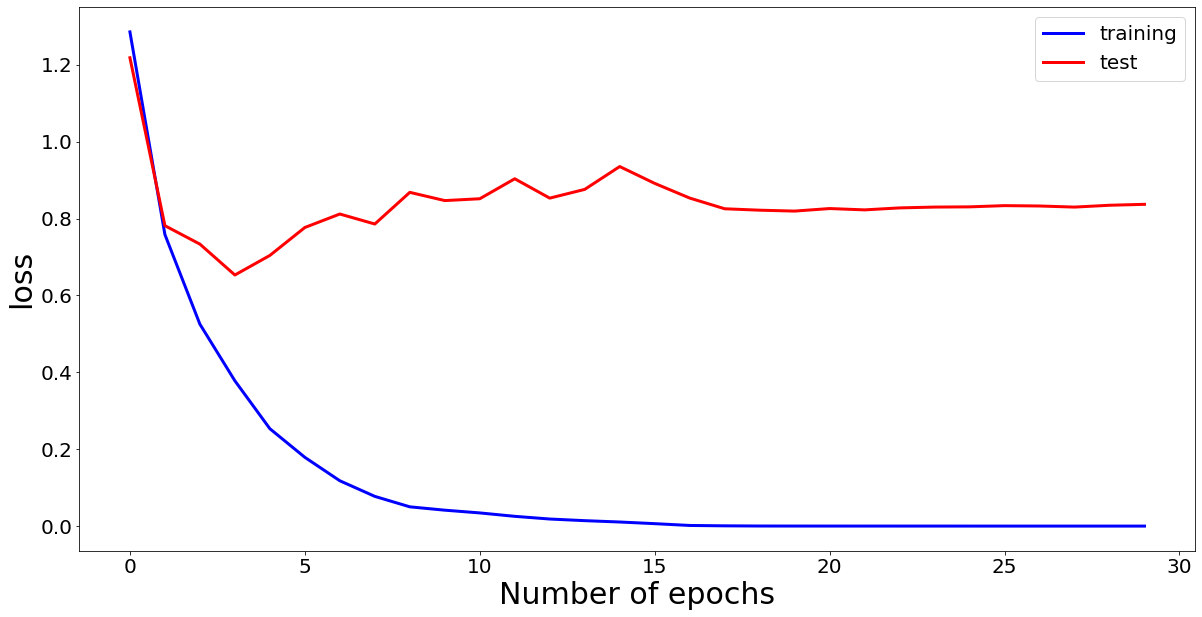

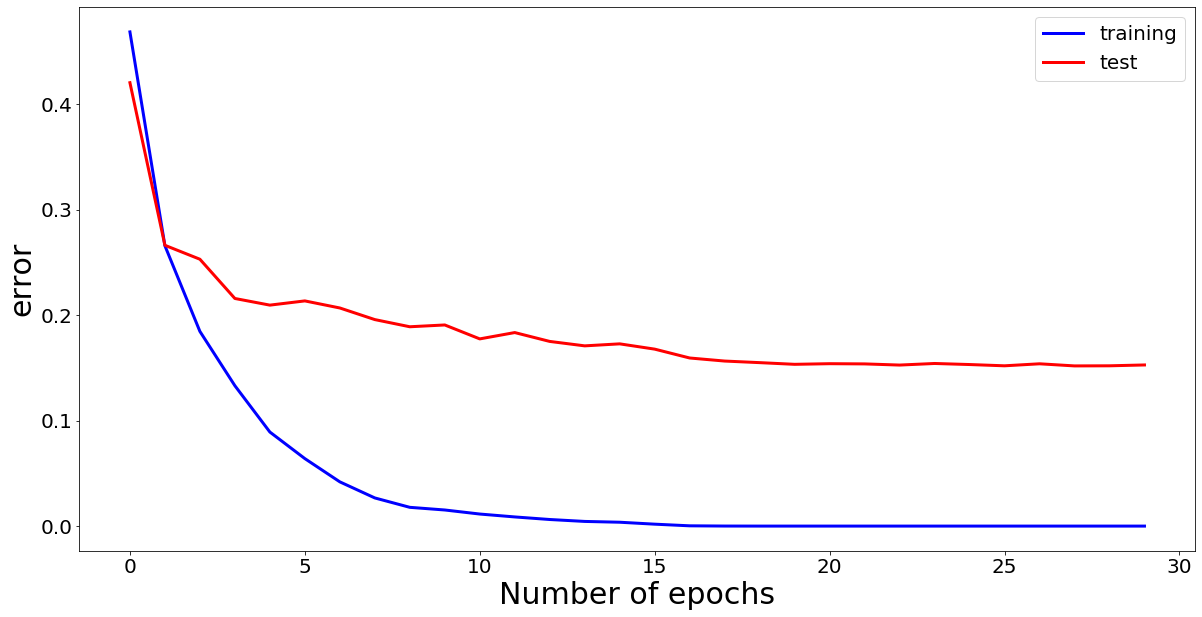

In [17]:
plot(log, './resnet_results/')
plt.show()

Training loss and error are both monotically decreasing. However, one should notice that
- test loss drops down first than grows up later, overfitting
- test error does not overfit with a continuous drop trend 